In [30]:
import os, random, json, pathlib, datetime, shutil, itertools, math
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import tensorflow as tf
import keras

from keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt

import pickle


In [2]:
import kagglehub
download = False

if download:
    path = kagglehub.dataset_download("shahriar26s/banana-ripeness-classification-dataset")
    print("Path to dataset files:", path)

100%|██████████| 221M/221M [00:06<00:00, 37.3MB/s] 

Extracting model files...


Path to dataset files: /Users/mattstoebe/.cache/kagglehub/datasets/shahriar26s/banana-ripeness-classification-dataset/versions/1


# Load data from Storage

In [14]:
import pathlib, os, tensorflow as tf

# 1. Your cache path
DATASET_ROOT = pathlib.Path(
    "/Users/mattstoebe/.cache/kagglehub/datasets/"
    "shahriar26s/banana-ripeness-classification-dataset/versions/1"
)

subfolders = [p for p in DATASET_ROOT.iterdir() if p.is_dir()]
if len(subfolders) != 1:
    raise RuntimeError(f"Expected exactly one subfolder under {DATASET_ROOT}, found: {subfolders}")
BASE_DIR = subfolders[0]

print("Using base directory:", BASE_DIR)
print("Contents:", [p.name for p in BASE_DIR.iterdir() if p.is_dir()])

TRAIN_DIR = BASE_DIR / "train"
VAL_DIR   = BASE_DIR / "valid"
TEST_DIR  = BASE_DIR / "test"

for d in (TRAIN_DIR, VAL_DIR, TEST_DIR):
    if not d.exists():
        raise RuntimeError(f"Directory not found: {d}")
    print(f"{d.name} has {sum(1 for _ in d.rglob('*.jpg'))} images")

Using base directory: /Users/mattstoebe/.cache/kagglehub/datasets/shahriar26s/banana-ripeness-classification-dataset/versions/1/Banana Ripeness Classification Dataset
Contents: ['valid', 'test', 'train']
train has 11793 images
valid has 1123 images
test has 562 images


# Utilities

In [20]:
def make_ds(path):
    return tf.keras.utils.image_dataset_from_directory(
        path,
        label_mode="int",
        image_size=IMG_SIZE,
        batch_size=BATCH,
        shuffle=True,
        seed=SEED
    )

def show_batch(ds, num = 5):
    plt.figure(figsize=(10, 10))
    for images, labels in ds.take(1):

        for i in range(num):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")

# Tensorflow Settings, Explore Data

In [32]:
BATCH = 32
IMG_SIZE = (224, 224)
SEED = 17
keras.utils.set_random_seed(SEED)
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = models.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

normalization = layers.Rescaling(1./255)

def preprocess_train(image, label):
    img = tf.cast(image, tf.float32)
    img = data_augmentation(img, training=True)
    img = normalization(img)
    return img, label

def preprocess_eval(image, label):
    img = tf.cast(image, tf.float32)
    img = normalization(img)
    return img, label


raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, label_mode="int", image_size=IMG_SIZE,
    batch_size=BATCH, shuffle=True, seed=SEED)
raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,  label_mode="int", image_size=IMG_SIZE,
    batch_size=BATCH, shuffle=True, seed=SEED)
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, label_mode="int", image_size=IMG_SIZE,
    batch_size=BATCH, shuffle=False, seed=SEED)

# capture class names and count _now_
class_names = raw_train_ds.class_names
num_classes = len(class_names)
print("Detected classes:", class_names)

# --- 2) Map your preprocessing onto those raw datasets ---
train_ds = raw_train_ds.map(preprocess_train, num_parallel_calls=AUTOTUNE)
val_ds   = raw_val_ds.map(  preprocess_eval,  num_parallel_calls=AUTOTUNE)
test_ds  = raw_test_ds.map( preprocess_eval,  num_parallel_calls=AUTOTUNE)

# cache / prefetch as before
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 11793 files belonging to 4 classes.
Found 1123 files belonging to 4 classes.
Found 562 files belonging to 4 classes.
Detected classes: ['overripe', 'ripe', 'rotten', 'unripe']


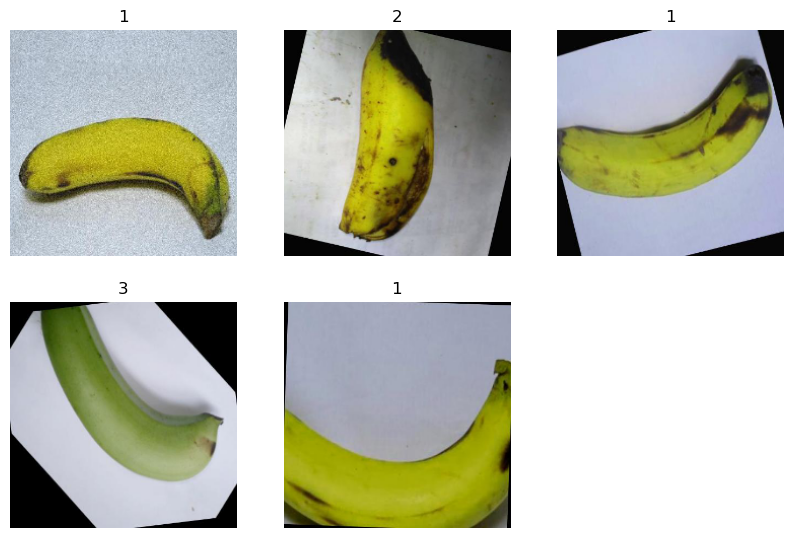

In [37]:
show_batch(raw_train_ds, 5)

In [40]:

model = models.Sequential([
    layers.Input(shape=IMG_SIZE + (3,)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax'),   # ← use num_classes here
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

cb = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ModelCheckpoint(
        'best_cnn_banana.keras',   # ← .keras extension
        monitor='val_accuracy',
        save_best_only=True
    )
]



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,276 (430.77 KB)

 Trainable params: 110,276 (430.77 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
QUICK_TRAIN_BATCHES = 50 
QUICK_VAL_BATCHES   = 10 

train_ds_small = train_ds.take(QUICK_TRAIN_BATCHES)
val_ds_small   = val_ds.take(QUICK_VAL_BATCHES)

# Fit on the smaller datasets
history = model.fit(
    train_ds_small,
    validation_data=val_ds_small,
    epochs=10,
    callbacks=cb
)


# 3) Persist the training history
with open('banana_classifier_history.pkl','wb') as f:
    pickle.dump(history.history, f)

print("Training complete. Weights in 'best_cnn_banana.h5', history in 'banana_classifier_history.pkl'")


Epoch 1/10
30/50 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7951 - loss: 0.4697